<a href="https://colab.research.google.com/github/ConstanzaSchibber/capstone_colors/blob/main/notebooks/2_Model_A_for_color_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model A: Identifying CIELAB Shade Leveraging Image Clustering

In this notebook, I explore a method for identifying CIELAB color shades in images using image clustering techniques. By leveraging the perceptual uniformity of the CIELAB color space, I aim to achieve more accurate color identification and analysis, which is crucial for makeup where precise color matching is required. This approach allows me to cluster and analyze images based on their color distributions, providing a robust framework for identifying and categorizing shades in a way that aligns with human visual perception.

First, I apply a k-means clustering algorithm to two test images to extract the colors of each cluster, determine the average color across clusters, and identify the peak (most frequent) color.

Next, I scale this approach to the entire dataset, beginning with a training set of images. I validate the algorithm's performance using a validation set, iteratively refining the model to minimize the distance between the color retrieve and the 'ground truth' color.

Finally, I evaluate the optimized algorithm on a test set to assess its effectiveness.



# Libraries

In [ ]:
!pip freeze > requirements2.txt
!pip list --format=freeze > requirements2.txt

In [3]:
import os
from getpass import getpass
import urllib
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image
import numpy as np

In [4]:
import cv2

In [5]:
from skimage.color import rgb2lab, lab2rgb

In [6]:
from skimage import color

In [7]:
import binascii
import struct
import scipy
import scipy.misc
import scipy.cluster

In [8]:
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [9]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]

# Test case 1

Before scaling up to multiple images, I applied the process to a single image. I used k-means clustering to identify dominant colors in the image, then converted the mean CIELAB color of these clusters to RGB, created a small square with this color, and overlaid it on the image.

K-means clustering is a good approach because it efficiently groups similar colors, making it easier to identify the most representative shades. However, a downside is that it requires deciding the number of clusters beforehand, which may not always reflect the actual color diversity in the image. However, most images are not color diverse (per the exploratory data analysis) and I can also identify which images are color diverse for further analysis.

In [ ]:
from google.colab import drive

# Mount Google Drive to access files stored there
# The 'force_remount=True' option ensures that the drive is remounted even if it is already mounted
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# path to test image
path = '/content/sample_data/1CBM_Fruit_Pigmented_Blush_Mauvette_Swatch_1260x.jpg'

In [ ]:
# read test image
swatch = cv2.imread(path)

OpenCV uses BGR as its default colour order for images, matplotlib uses RGB. When displaying an image loaded with OpenCv in matplotlib the channels will be back to front.

The easiest way of fixing this is to use OpenCV to explicitly convert it back to RGB.

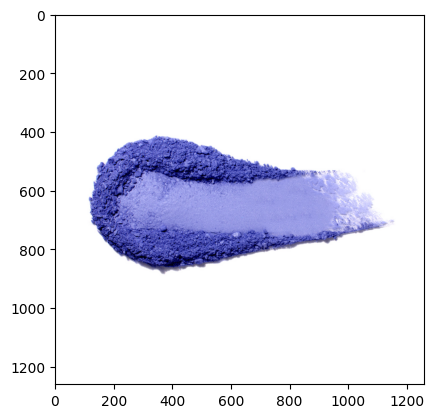

In [ ]:
plt.imshow(swatch)
plt.show()

In [ ]:
RGB_img = cv2.cvtColor(swatch, cv2.COLOR_BGR2RGB)


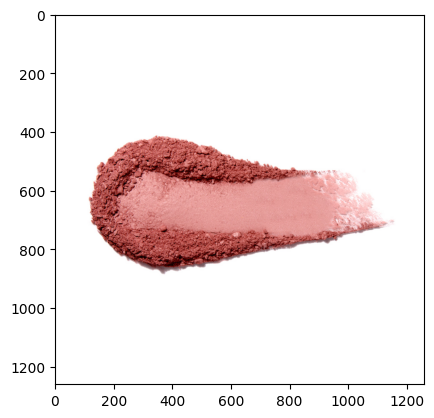

In [ ]:
plt.imshow(RGB_img)
plt.show()

The `rgb2lab()` function is utilized to convert the RGB image into the Lab color space, separating luminosity from color.

In [ ]:
im1 = rgb2lab(RGB_img)

In [ ]:
im1.shape

(1260, 1260, 3)

## K-Means Clustering

This code reads an image, resizes it for efficiency, and then converts it into a numpy array. It uses k-means clustering to identify color clusters within the image, with the number of clusters set to 3. After determining the cluster centers, it assigns each pixel to a cluster and counts the occurrences of each cluster. Finally, the code identifies the color of the five clusters, averages over five colors, and also identifies the most frequent color cluster in the image (which in this case, is white because of the background). It also converts the mean color and the most frequent color to the CIELAB color scale.

In [ ]:
# Number of cluster
NUM_CLUSTERS = 4

# Read the image
im = Image.open(path)

# Optionally resize the image to reduce processing time
im = im.resize((150, 150))

# Convert the image to a numpy array
ar = np.asarray(im)

# Store the shape of the array
shape = ar.shape

# Reshape the array for clustering
ar = ar.reshape(np.prod(shape[:2]), shape[2]).astype(float)

# Perform k-means clustering to find color clusters
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)

# Print the RGB values of the cluster centers
print('cluster centres in RGB:\n', codes)

# Assign each pixel to a cluster and count occurrences
vecs, dist = scipy.cluster.vq.vq(ar, codes)
counts, bins = np.histogram(vecs, len(codes))

# Find the index of the most frequent cluster
index_max = np.argmax(counts)
peak = codes[index_max]

# Print all the cluster centers
#print(codes)

# Average over the color of the clusters
columns_average = codes.mean(axis=0)

# Convert the peak color from RGB to CIELAB
mean_rgb = np.array(columns_average).reshape(1, 1, 3) / 255  # normalize RGB values to [0, 1]
mean_xyz = color.rgb2xyz(mean_rgb)  # convert to XYZ
mean_lab = color.xyz2lab(mean_xyz)  # convert to CIELAB

print('average color in CIELAB:', mean_lab[0][0])

# Convert the most frequent color from RGB to CIELAB
peak_rgb = np.array(peak).reshape(1, 1, 3) / 255  # normalize RGB values to [0, 1]
peak_xyz = color.rgb2xyz(peak_rgb)  # convert to XYZ
peak_lab = color.xyz2lab(peak_xyz)  # convert to CIELAB

print('most frequent color in CIELAB:', peak_lab[0][0])

cluster centres in RGB:
 [[180.0993007   87.22657343  83.43636364]
 [126.01156069  43.80057803  41.38872832]
 [227.54484733 155.82585878 153.40458015]
 [254.88939941 254.51679247 254.51815994]]
average color in CIELAB: [62.51884385 23.38958893 10.75796929]
most frequent color in CIELAB: [9.98606866e+01 1.20454023e-01 4.72355199e-02]


## Comparing Color Identified from K-Means Clustering and Image

Below, I created a small square filled with the average color in the top-left corner on the original image. This allows me to visually compare the mean color with the colors in the image.

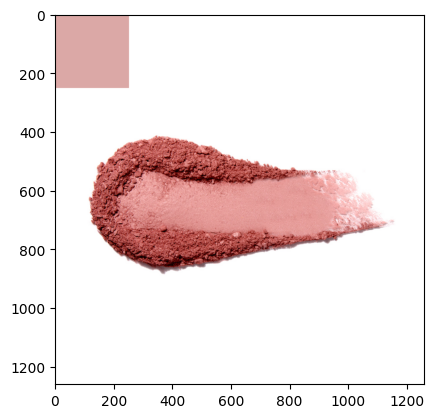

In [ ]:
# Display the original image
plt.imshow(RGB_img)

# Overlay a square with the mean RGB color
# Here, we create a small patch of color in the top-left corner
height, width, _ = RGB_img.shape
square_size = min(height, width) // 5  # Size of the square relative to the image size
square_patch = np.ones((square_size, square_size, 3)) * mean_rgb *255 # Create the square with the mean RGB color

# Place the square patch on the image
RGB_img[:square_size, :square_size] = square_patch

# Display the image with the overlay
plt.imshow(RGB_img)
plt.show()

# Test 2 (`.png` Image)

PNG images, like the one below, include an alpha channel, which represents transparency. This is common in PNG images but can cause issues when displaying or processing the image if the software or code isn't prepared to handle the additional channel. The alpha channel is not necessary for color analysis and might interfere with visualization or processing.

I performed a second test with a PNG image to ensure that the code handles images with an alpha channel properly. I added an `if` statement to delete the alpha channel. In this way,the image processing and display functions work correctly regardless of whether the image has an alpha channel or not.


In [ ]:
# path to test image
path = '/content/sample_data/juicypangwaterblusherCR01.png'

In [ ]:
# read test image
swatch2 = cv2.imread(path)
RGB_img2 = cv2.cvtColor(swatch2, cv2.COLOR_BGR2RGB)

In [ ]:
# Number of cluster
NUM_CLUSTERS = 4

# Read the image
im = Image.open(path)

# Optionally resize the image to reduce processing time
im = im.resize((150, 150))

# Convert the image to a numpy array
ar = np.asarray(im)

# Store the shape of the array
shape = ar.shape

if len(shape) == 2:
    # No need to convert to RGB; use grayscale values directly
    num_channels = 1
elif len(shape) == 3 and shape[2] in [3, 4]:
    # RGB or RGBA image
    if shape[2] == 4:
    # Remove the alpha channel
      ar = ar[:, :, :3]
    num_channels = 3
else:
    raise ValueError("Unsupported image format")

shape = ar.shape

# Reshape the array for clustering
ar = ar.reshape(np.prod(shape[:2]), num_channels).astype(float)

# Perform k-means clustering to find color clusters
codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)

# Print the RGB values of the cluster centers
print('cluster centres in RGB:\n', codes)

# Assign each pixel to a cluster and count occurrences
vecs, dist = scipy.cluster.vq.vq(ar, codes)
counts, bins = np.histogram(vecs, len(codes))

# Find the index of the most frequent cluster
index_max = np.argmax(counts)
peak = codes[index_max]

# Print all the cluster centers
#print(codes)

# Average over the color of the clusters
columns_average = codes.mean(axis=0)

# Convert the average color from RGB or grayscale to CIELAB
if num_channels == 1:
  # For grayscale, directly use the average intensity value
  mean_lab = np.array([columns_average.mean(), 0, 0])  # Dummy LAB values
  print('Average color in CIELAB:', mean_lab)
else:
  mean_rgb = np.array(columns_average).reshape(1, 1, num_channels) / 255  # Normalize RGB values to [0, 1]
  mean_xyz = color.rgb2xyz(mean_rgb)  # Convert to XYZ
  mean_lab = color.xyz2lab(mean_xyz)  # Convert to CIELAB
  print('Average color in CIELAB:', mean_lab[0][0])

# Convert the most frequent color from RGB or grayscale to CIELAB
if num_channels == 1:
  # For grayscale, directly use the peak intensity value
  peak_lab = np.array([peak.mean(), 0, 0])  # Dummy LAB values
  print('Most frequent color in CIELAB:', peak_lab)
else:
  peak_rgb = np.array(peak).reshape(1, 1, num_channels) / 255  # Normalize RGB values to [0, 1]
  peak_xyz = color.rgb2xyz(peak_rgb)  # Convert to XYZ
  peak_lab = color.xyz2lab(peak_xyz)  # Convert to CIELAB
  print('Most frequent color in CIELAB:', peak_lab[0][0])

cluster centres in RGB:
 [[253.63989124 253.22081233 253.20976605]
 [241.00936937 104.06522523  85.71135135]
 [229.8503861  139.47586873 131.74324324]]
Average color in CIELAB: [75.04245714 26.95509481 15.89110902]
Most frequent color in CIELAB: [9.94163985e+01 1.33729474e-01 5.85799803e-02]


In [ ]:
variance = np.var(ar)

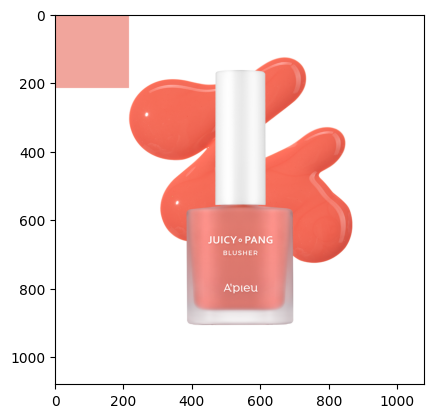

In [ ]:
# Display the original image
plt.imshow(RGB_img2)

# Overlay a square with the mean RGB color
# Here, we create a small patch of color in the top-left corner
height, width, _ = RGB_img2.shape
square_size = min(height, width) // 5  # Size of the square relative to the image size
square_patch = np.ones((square_size, square_size, 3)) * mean_rgb * 255 # Create the square with the mean RGB color

# Place the square patch on the image
RGB_img2[:square_size, :square_size] = square_patch

# Display the image with the overlay
plt.imshow(RGB_img2)
plt.show()

# Scaling to All of the Images

In this section, I scale up the approach I developed with 1 image to all the images. First, I read the images and then split them into training, validation, and test sets. Then, I implement scale the algorithm, and finally I conduct validate and test them.

## Reading Data

First, I read a table in which I have metadata for each image as well as the name of the image. If I read all of the images directly, it would take too much RAM, so with this information, I can then read one image at a time.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/processed/data_1.csv')
df.columns

Index(['Unnamed: 0', 'level_0', 'index', 'category', 'joined', 'brand',
       'product', 'shade', 'img_url', 'shade_description_original', 'id',
       'validation', 'img_name'],
      dtype='object')

From the exploratory data analysis, I found that the following file `mac_smoosh_S7GR08.jpg` was corrupted, so I delete the image from the table.

I also delete the cases in which the image was not available at the link (errors `404` and `403`).

In [ ]:
df.shape

(527, 13)

In [ ]:
df = df[df.img_name != 'mac_smoosh_S7GR08.jpg']
df.shape

(526, 13)

In [ ]:
df = df[df.img_name != '404']
df = df[df.img_name != '403']
df.shape

(506, 13)

In [ ]:
df = df.reset_index(drop=True)

There are also 2 cases that are duplicated. The images have the same name (and thus, the same link).

## Splitting into Train, Validation, Test Sets

Dividing data into training, validation, and test sets helps evaluate model performance, avoid overfitting, and ensure that the model generalizes well to new, unseen data. Training data is used to build the model, validation data to tune hyperparameters, and test data to assess final performance.

In [184]:
from sklearn.model_selection import train_test_split

# Split data into training and temporary sets (which will be further split into validation and test sets)
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)

# Split the temporary set into validation and test sets
validation_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f'Training set: {len(train_df)} samples')
print(f'Validation set: {len(validation_df)} samples')
print(f'Test set: {len(test_df)} samples')

Training set: 303 samples
Validation set: 101 samples
Test set: 102 samples


## Round 1: Implementing Algorithm & Validating

I transform the code that I developed to analyze one image into a function. Then, I apply the function to every image and save the average color and peak color into the metadata.

In [ ]:
def analyze_image_colors(image_path, num_clusters=4):
    """
    Analyzes the colors in an image using k-means clustering and converts the dominant color
    to CIELAB color space.

    Parameters:
    - image_path (str): Path to the image file.
    - num_clusters (int): Number of clusters for k-means.

    Returns:
    - tuple: Average color and most frequent color in CIELAB color space.
    """

    # Read the image
    im = Image.open(image_path)

    # Optionally resize the image to reduce processing time
    im = im.resize((150, 150))

    # Convert the image to a numpy array
    ar = np.asarray(im)

    # Variance in color values
    sd_color = np.sqrt(np.var(ar))

    # Store the shape of the array
    shape = ar.shape

    # Check the number of channels in the image
    if len(shape) == 2:
    # No need to convert to RGB; use grayscale values directly
      num_channels = 1
    elif len(shape) == 3 and shape[2] in [3, 4]:
      # RGB or RGBA image
      if shape[2] == 4:
      # Remove the alpha channel
        ar = ar[:, :, :3]
      num_channels = 3
    else:
      raise ValueError("Unsupported image format")

    shape = ar.shape

    # Reshape the array for clustering
    ar = ar.reshape(np.prod(shape[:2]), num_channels).astype(float)

    # Reshape the array for clustering
    #ar = ar.reshape(np.prod(shape[:2]), shape[2]).astype(float)

    # Perform k-means clustering to find color clusters
    codes, dist = scipy.cluster.vq.kmeans(ar, num_clusters)

    # Assign each pixel to a cluster and count occurrences
    vecs, dist = scipy.cluster.vq.vq(ar, codes)
    counts, bins = np.histogram(vecs, len(codes))

    # Find the index of the most frequent cluster
    index_max = np.argmax(counts)
    peak = codes[index_max]

    # Average over the color of the clusters
    columns_average = codes.mean(axis=0)

    # Convert the average color from RGB or grayscale to CIELAB
    if num_channels == 1:
      # For grayscale, directly use the average intensity value
      mean_lab = np.array([columns_average.mean(), 0, 0])  # Dummy LAB values
      #print('Average color in CIELAB:', mean_lab)
    else:
      mean_rgb = np.array(columns_average).reshape(1, 1, num_channels) / 255  # Normalize RGB values to [0, 1]
      mean_xyz = color.rgb2xyz(mean_rgb)  # Convert to XYZ
      mean_lab = color.xyz2lab(mean_xyz)  # Convert to CIELAB
      #print('Average color in CIELAB:', mean_lab[0][0])

    # Convert the most frequent color from RGB or grayscale to CIELAB
    if num_channels == 1:
      # For grayscale, directly use the peak intensity value
      peak_lab = np.array([peak.mean(), 0, 0])  # Dummy LAB values
      #print('Most frequent color in CIELAB:', peak_lab)
    else:
      peak_rgb = np.array(peak).reshape(1, 1, num_channels) / 255  # Normalize RGB values to [0, 1]
      peak_xyz = color.rgb2xyz(peak_rgb)  # Convert to XYZ
      peak_lab = color.xyz2lab(peak_xyz)  # Convert to CIELAB
      #print('Most frequent color in CIELAB:', peak_lab[0][0])

    if num_channels == 1:
      return mean_lab, peak_lab, sd_color
    else:
      return mean_lab[0][0], peak_lab[0][0], sd_color

Apply the function to every image:

In [ ]:
df['mean_lab'] = pd.Series(dtype='object')
df['peak_lab'] = pd.Series(dtype='object')
df['sd_color'] = pd.Series(dtype='float')

In [ ]:
for i in range(len(df)):
  #print(str(df.img_name[i]))
  path = '/content/drive/MyDrive/makeup_img/' + str(df.img_name[i])
  colors_output = analyze_image_colors(path)
  mean_value = list(colors_output[0])
  peak_value = list(colors_output[1])
  df.at[i, 'mean_lab'] = mean_value
  df.at[i, 'peak_lab'] = peak_value
  df.loc[i, 'sd_color'] = colors_output[2]

In [ ]:
df.mean_lab.info()

<class 'pandas.core.series.Series'>
RangeIndex: 506 entries, 0 to 505
Series name: mean_lab
Non-Null Count  Dtype 
--------------  ----- 
506 non-null    object
dtypes: object(1)
memory usage: 4.1+ KB


In [ ]:
df.peak_lab.info()

<class 'pandas.core.series.Series'>
RangeIndex: 506 entries, 0 to 505
Series name: peak_lab
Non-Null Count  Dtype 
--------------  ----- 
506 non-null    object
dtypes: object(1)
memory usage: 4.1+ KB


In [ ]:
df.sd_color.info()

<class 'pandas.core.series.Series'>
RangeIndex: 506 entries, 0 to 505
Series name: sd_color
Non-Null Count  Dtype  
--------------  -----  
506 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


In [ ]:
df.sd_color.describe()

,sd_color
count,506.000000
mean,59.517631
std,20.462309
min,8.029022
25%,43.788828
50%,58.027354
75%,72.282976
max,112.982690


In [ ]:
df.head()

,Unnamed: 0,level_0,index,category,joined,brand,product,shade,img_url,shade_description_original,id,validation,img_name,mean_lab,peak_lab,sd_color
0,0,0,1,blush,14e cosmetics blush sunset,14e cosmetics,blush,sunset,https://images.squarespace-cdn.com/content/v1/...,warm peachy,1,True,Sunset.jpg,"[66.58852380011785, 12.013991165505056, 11.397...","[99.82396122228114, 0.02705588252999158, 0.056...",61.523435
1,1,1,2,blush,a'pieu juicy-pang water blusher cr01,a'pieu,juicy-pang water blusher,cr01,https://misshaus.com/cdn/shop/files/juicypangw...,peach,2,True,juicypangwaterblusherCR01.png,"[77.9584528115023, 21.34906646297241, 12.19519...","[99.83268413824078, 0.012533767436373466, 0.01...",44.900879
2,2,2,3,blush,about-face cheek freak blush balm raunchy,about-face,cheek freak blush balm,raunchy,https://aboutface.com/cdn/shop/products/CF_PDP...,nude peach,3,True,CF_PDP_Raunchy_swatch.png,"[64.99980005368049, 24.96126109346031, 20.6970...","[99.89412983302098, 0.03107937071972211, 0.112...",56.386499
3,3,3,6,blush,alamar cosmetics colorete concentrate liquid b...,alamar cosmetics,colorete concentrate liquid blush,amor de melocoton,https://alamarcosmetics.com/cdn/shop/products/...,creamy peach,4,True,Product5_540x.png,"[54.04044072395696, 9.387643265109102, 17.1388...","[0.00218713264549919, 0.0027841989377885845, 0...",74.550748
4,4,4,13,blush,anastasia beverly hills stick cream blush peac...,anastasia beverly hills,stick cream blush,peachy keen,https://www.sephora.com/productimages/sku/s247...,soft peach,5,True,s2474427-av-04-zoom.jpg,"[69.29394788509994, 18.51960306972472, 9.71182...","[99.89888265934047, 0.0649875290941182, 0.0571...",43.556566


### Save Results

In [ ]:
df1 = pd.DataFrame(df)

In [ ]:
df1.columns

Index(['Unnamed: 0', 'level_0', 'index', 'category', 'joined', 'brand',
       'product', 'shade', 'img_url', 'shade_description_original', 'id',
       'validation', 'img_name', 'mean_lab', 'peak_lab', 'sd_color'],
      dtype='object')

In [ ]:
df1 = df1.drop(['Unnamed: 0', 'level_0', 'index'], axis=1)

In [ ]:
df1.to_csv('/content/drive/My Drive/data_2.csv')

### Validation

I merge the 'ground truth' color value to the validation set. Then, calculate the color distance between the 'ground truth' and the color identify by the algorithm.

In [ ]:
# read metadata
metadata = pd.read_csv('/content/drive/MyDrive/data/processed/metadata_ground_truth.csv')

#subset data that needs to be merged
metadata_mini = metadata[['id', 'ground_truth', 'ground_truth_CIELAB']]

# merge metadata and model output
df_all = df1.merge(metadata_mini, how = 'left', on='id')

In [ ]:
df_all.head()

,category,joined,brand,product,shade,img_url,shade_description_original,id,validation,img_name,mean_lab,peak_lab,sd_color,ground_truth,ground_truth_CIELAB
0,blush,14e cosmetics blush sunset,14e cosmetics,blush,sunset,https://images.squarespace-cdn.com/content/v1/...,warm peachy,1,True,Sunset.jpg,"[66.58852380011785, 12.013991165505056, 11.397...","[99.82396122228114, 0.02705588252999158, 0.056...",61.523435,1,[38.19553169 47.68982678 36.88843393]
1,blush,a'pieu juicy-pang water blusher cr01,a'pieu,juicy-pang water blusher,cr01,https://misshaus.com/cdn/shop/files/juicypangw...,peach,2,True,juicypangwaterblusherCR01.png,"[77.9584528115023, 21.34906646297241, 12.19519...","[99.83268413824078, 0.012533767436373466, 0.01...",44.900879,1,[61.88009784 51.78571037 37.06808969]
2,blush,about-face cheek freak blush balm raunchy,about-face,cheek freak blush balm,raunchy,https://aboutface.com/cdn/shop/products/CF_PDP...,nude peach,3,True,CF_PDP_Raunchy_swatch.png,"[64.99980005368049, 24.96126109346031, 20.6970...","[99.89412983302098, 0.03107937071972211, 0.112...",56.386499,1,[62.69092851 46.94025593 38.21046511]
3,blush,alamar cosmetics colorete concentrate liquid b...,alamar cosmetics,colorete concentrate liquid blush,amor de melocoton,https://alamarcosmetics.com/cdn/shop/products/...,creamy peach,4,True,Product5_540x.png,"[54.04044072395696, 9.387643265109102, 17.1388...","[0.00218713264549919, 0.0027841989377885845, 0...",74.550748,1,[74.97378875 27.83931397 24.01907716]
4,blush,anastasia beverly hills stick cream blush peac...,anastasia beverly hills,stick cream blush,peachy keen,https://www.sephora.com/productimages/sku/s247...,soft peach,5,True,s2474427-av-04-zoom.jpg,"[69.29394788509994, 18.51960306972472, 9.71182...","[99.89888265934047, 0.0649875290941182, 0.0571...",43.556566,1,[68.14449353 29.27877044 16.28918275]


Next, I identify the validation set and calculate the color distance to assess how close the estimate and the ground truth are.

To do this, I calculate Delta E (ΔE) which is a metric that quantifies the difference between two colors in the CIELAB color space. It calculates the distance between two points (representing colors) in the three-dimensional CIELAB space, where L* represents lightness, and a* and b* represent color-opponent dimensions.

Delta E is measured on a scale of 0 to 100. A lower ΔE value indicates that the two colors are very similar to each other, while a higher ΔE value suggests a more noticeable difference. Delta E is widely used in color matching and quality control to assess how close two colors are to being identical.

See also [color difference](https://en.wikipedia.org/wiki/Color_difference) in Wikipedia.

In [129]:
from skimage.color import deltaE_ciede2000

In [ ]:
df_all['diff_lab'] = pd.Series(dtype='object')

for i in range(len(df_all)):
  if df_all.ground_truth[i] == 1:
    diff = deltaE_ciede2000(df_all.mean_lab[i], list(map(float, df_all.ground_truth_CIELAB[i].strip('[]').split())))
    df_all.loc[i, 'diff_lab'] = diff
  else:
    df_all.loc[i, 'diff_lab'] = np.nan

In [ ]:
df_all.diff_lab.mean()

19.324833958901305

Below is a histogram for Delta E each observation in the validation set. For a ΔE value of 0 indicates that the colors are identical, while values up to 10 suggest that the colors are similar. For color-matching applications, a threshold between 10 and 15 is generally effective (see [Color Difference Estimation](https://medium.com/@bhuwankhatiwada57/color-difference-estimation-using-cie-l-a-b-color-space-b415f97a6b94) and [Delta E - A Survey](https://wisotop.de/assets/2017/DeltaE-%20Survey-2.pdf))

The mean Delta E is 19.3.

However, the optimal threshold varies depending on the specific application. With more time and funding, in the future, I could conduct tests or surveys with users to determine at what ΔE they perceive a difference as significant. This could help tailor the threshold to real-world preferences.

In [185]:
df_t_v = pd.concat([train_df, validation_df], axis=0)
df_t_v.shape

(404, 25)

In [ ]:
df_val = pd.merge(df_all, df_t_v['id'], how='inner', on='id')
df_val.shape

(404, 16)

In [ ]:
df_val.diff_lab.median()

17.91674791243618

<Axes: >

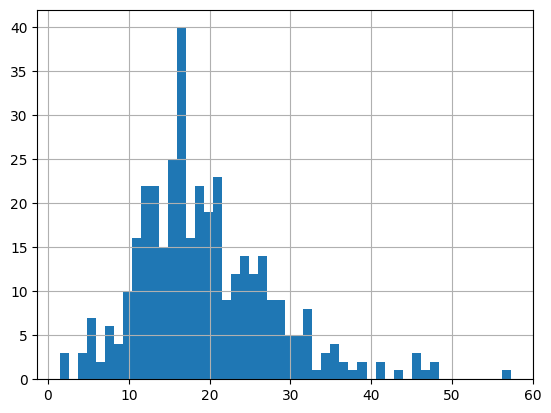

In [ ]:
df_val.diff_lab.hist(bins=50)

We can also look at Delta E by product category. Below, we see that 'Delta E' is tends to be larger for 'lipstick', probably because lipstick is in a container and the color of the container is confounded with the color of the makeup.

Moreover, looking at the mean Delta E per product, blush has a mean of 16, lipgloss a mean of 19, while lipliner and lipstick have a higher Delta E of 24.4 and 21.4 respectively. The Delta E variance for these two product categories is also considerably higher than for the other categories.

Overall, the higher mean and variance of Delta E for lipliner and lipsticks compared to blush suggest that the color measurements for these products are less consistent and less reliable. This variability may be due to the confounding effect of the container color, which can influence the color identified through the k-means algorithm and result in greater discrepancies in color matching.

In terms of reliability, this higher variance indicates that the color measurements for lipliner and lipsticks are less stable across different samples, leading to less consistent results.

In terms of validity, the presence of confounding colors (e.g., container colors) can affect the accuracy of color measurements, making it harder to accurately represent the true color of the makeup products. This can reduce the validity of the color matching process, as the measurements may not accurately reflect the product’s actual color.

/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


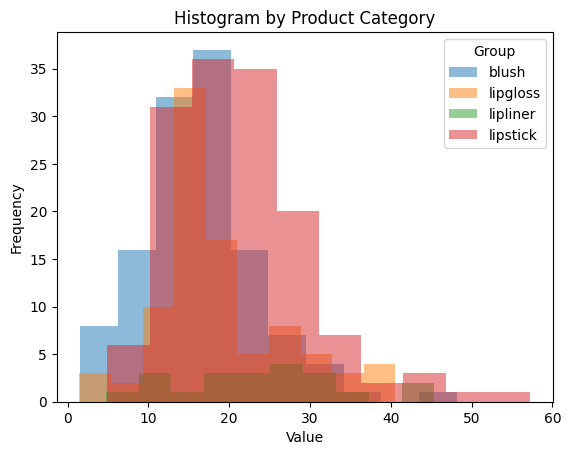

In [ ]:
# histogram with delta E by product category
# Create a figure and axis
fig, ax = plt.subplots()

# Group by the 'Group' column and plot a histogram for each group
for name, group in df_val.groupby('category'):
    ax.hist(group['diff_lab'], bins=10, alpha=0.5, label=name)

# Add labels and legend
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram by Product Category')
ax.legend(title='Group')

# Show the plot
plt.show()

In [ ]:
product_deltaE = df_val.diff_lab.groupby(df_val.category).mean()
product_deltaE = product_deltaE.reset_index()
product_deltaE.columns = ['product category', 'Delta E']

print('Table: DeltaE (mean) by Product')
product_deltaE

Table: DeltaE (mean) by Product


,product category,Delta E
0,blush,16.457209
1,lipgloss,19.108062
2,lipliner,24.471992
3,lipstick,21.478627


In [ ]:
product_deltaE = df_val.diff_lab.groupby(df_val.category).var()
product_deltaE = product_deltaE.reset_index()
product_deltaE.columns = ['product category', 'Delta E']

print('Table: DeltaE (SD) by Product')
product_deltaE

Table: DeltaE (SD) by Product


,product category,Delta E
0,blush,50.643298
1,lipgloss,62.29745
2,lipliner,110.389342
3,lipstick,75.006309


## Round 2: Making Changes to the Algorithm to Improve Color Matching for Lipstick and Lipgloss

### Focusing on `Peak` Color from Cluster Analysis

Many makeup containers and image backgrounds include black or white colors. By comparing the Delta E values of the peak color (most common color) with black and white, I can determine if these colors are incorrectly influencing the color analysis. If black and white are frequently identified, it indicates they might be artifacts rather than actual makeup colors. I will adjust the algorithm to filter out clusters with these colors, enhancing the accuracy of the makeup color detection.

First, I calculate the Delta E between `peak color` and the color black:

In [ ]:
df_all['diff_peak_black'] = pd.Series(dtype='object')

for i in range(len(df_all)):
  if df_all.ground_truth[i] == 1:
    diff = deltaE_ciede2000(df_all.peak_lab[i], [0,0,0])
    df_all.loc[i, 'diff_peak_black'] = diff
  else:
    df_all.loc[i, 'diff_peak_black'] = np.nan

Second, I calculate the Delta E between `peak color` and the color white:

In [ ]:
df_all['diff_peak_white'] = pd.Series(dtype='object')

for i in range(len(df_all)):
  if df_all.ground_truth[i] == 1:
    diff = deltaE_ciede2000(df_all.peak_lab[i], [100,0,0])
    df_all.loc[i, 'diff_peak_white'] = diff
  else:
    df_all.loc[i, 'diff_peak_white'] = np.nan

Now, I look at the histograms for Delta E between `peak color` for each image in the validation set and the colors black and white.

In [ ]:
df_val = pd.merge(df_all, df_t_v['id'], how='inner', on='id')
df_val.shape

(404, 18)

Below, we see that white is a very common color and while black is less common, it is still a frequent.

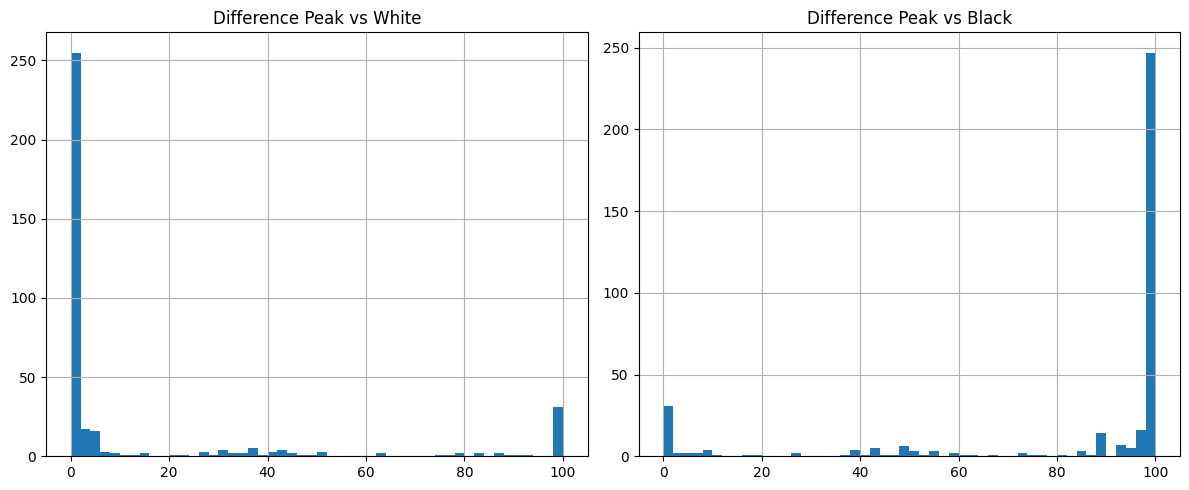

In [ ]:
# Create a figure and two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first histogram on the left subplot
df_val.diff_peak_white.hist(bins=50, ax=axes[0])
axes[0].set_title('Difference Peak vs White')

# Plot the second histogram on the right subplot
df_val.diff_peak_black.hist(bins=50, ax=axes[1])
axes[1].set_title('Difference Peak vs Black')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Improving `analyze_image_colors` function

I added this step to the algorithm to improve the accuracy of makeup color detection by filtering out clusters that represent black or white, which are common in container colors and image backgrounds. By calculating the Delta E between the peak color and both black and white, I can identify clusters where the peak color closely matches these non-makeup colors (Delta E < 5). If such a match is found, the corresponding cluster is removed from the analysis, ensuring that the algorithm focuses on identifying actual makeup colors rather than being influenced by irrelevant black or white elements.

This is the specific section added:

```
# Calculate difference between peak & white
diff_peak_white = deltaE_ciede2000(codes[index_max], [100,0,0])

# Calculate difference between peak & black
diff_peak_black = deltaE_ciede2000(codes[index_max], [0,0,0])

# Filter out clusters with black or white if Delta E < 5
if diff_peak_white < 5:
  codes = np.delete(codes, index_max, axis=0)
if diff_peak_black < 5:
  codes = np.delete(codes, index_max, axis=0)```



In [ ]:
def analyze_image_colors(image_path, num_clusters=4):
    """
    Analyzes the colors in an image using k-means clustering and converts the dominant color
    to CIELAB color space.

    Parameters:
    - image_path (str): Path to the image file.
    - num_clusters (int): Number of clusters for k-means.

    Returns:
    - tuple: Average color and most frequent color in CIELAB color space.
    """

    # Read the image
    im = Image.open(image_path)

    # Optionally resize the image to reduce processing time
    im = im.resize((150, 150))

    # Convert the image to a numpy array
    ar = np.asarray(im)

    # Variance in color values
    sd_color = np.sqrt(np.var(ar))

    # Store the shape of the array
    shape = ar.shape

    # Check the number of channels in the image
    if len(shape) == 2:
    # No need to convert to RGB; use grayscale values directly
      num_channels = 1
    elif len(shape) == 3 and shape[2] in [3, 4]:
      # RGB or RGBA image
      if shape[2] == 4:
      # Remove the alpha channel
        ar = ar[:, :, :3]
      num_channels = 3
    else:
      raise ValueError("Unsupported image format")

    shape = ar.shape

    # Reshape the array for clustering
    ar = ar.reshape(np.prod(shape[:2]), num_channels).astype(float)

    # Perform k-means clustering to find color clusters
    codes, dist = scipy.cluster.vq.kmeans(ar, num_clusters)

    # Assign each pixel to a cluster and count occurrences
    vecs, dist = scipy.cluster.vq.vq(ar, codes)
    counts, bins = np.histogram(vecs, len(codes))

    # Find the index of the most frequent cluster
    index_max = np.argmax(counts)
    peak = codes[index_max]

    # Average over the color of the clusters
    columns_average = codes.mean(axis=0)

    # Convert the average color from RGB or grayscale to CIELAB
    if num_channels == 1:
      # Directly use the average intensity value
      mean_lab = np.array([columns_average.mean(), 0, 0])  # Dummy LAB values
      peak_lab = np.array([peak.mean(), 0, 0])  # Dummy LAB values

    else:
      # Calculate difference between peak & white
      diff_peak_white = deltaE_ciede2000(codes[index_max], [100,0,0])

      # Calculate difference between peak & black
      diff_peak_black = deltaE_ciede2000(codes[index_max], [0,0,0])

      peak_rgb = np.array(peak).reshape(1, 1, num_channels) / 255  # Normalize RGB values to [0, 1]
      peak_xyz = color.rgb2xyz(peak_rgb)  # Convert to XYZ
      peak_lab = color.xyz2lab(peak_xyz)  # Convert to CIELAB

      # Filter out clusters with black or white if Delta E < 5
      if diff_peak_white < 5:
        codes = np.delete(codes, index_max, axis=0)
      if diff_peak_black < 5:
        codes = np.delete(codes, index_max, axis=0)

      # Average over the color of the clusters after dropping peak
      columns_average = codes.mean(axis=0)
      mean_rgb = np.array(columns_average).reshape(1, 1, num_channels) / 255  # Normalize RGB values to [0, 1]
      mean_xyz = color.rgb2xyz(mean_rgb)  # Convert to XYZ
      mean_lab = color.xyz2lab(mean_xyz)  # Convert to CIELAB

    if num_channels == 1:
      return mean_lab, peak_lab
    else:
      return mean_lab[0][0], peak_lab[0][0]

In [ ]:
df_all['mean_lab_2'] = pd.Series(dtype='object')
df_all['peak_lab_2'] = pd.Series(dtype='object')

In [ ]:
for i in range(len(df)):
  #print(str(df.img_name[i]))
  path = '/content/drive/MyDrive/makeup_img/' + str(df.img_name[i])
  colors_output = analyze_image_colors(path)
  mean_value = list(colors_output[0])
  peak_value = list(colors_output[1])
  df_all.at[i, 'mean_lab_2'] = mean_value
  df_all.at[i, 'peak_lab_2'] = peak_value

In [ ]:
df['mean_lab_2'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 506 entries, 0 to 505
Series name: mean_lab_2
Non-Null Count  Dtype 
--------------  ----- 
0 non-null      object
dtypes: object(1)
memory usage: 4.1+ KB


In [ ]:
df['peak_lab_2'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 506 entries, 0 to 505
Series name: peak_lab_2
Non-Null Count  Dtype 
--------------  ----- 
0 non-null      object
dtypes: object(1)
memory usage: 4.1+ KB


### Validation

I follow the same steps as before.

First, I calculate Delta E between the color output from the algorithm and the 'ground truth' color.

In [ ]:
df_all['diff_lab_2'] = pd.Series(dtype='object')

for i in range(len(df_all)):
  if df_all.ground_truth[i] == 1:
    diff = deltaE_ciede2000(df_all.mean_lab_2[i], list(map(float, df_all.ground_truth_CIELAB[i].strip('[]').split())))
    df_all.loc[i, 'diff_lab_2'] = diff
  else:
    df_all.loc[i, 'diff_lab_2'] = np.nan

Second, I plot a histogram for previous Delta E (red) and a histogram for the new Delta E (green) for each observation in the validation set.

The mean Delta E previously was 19.4, and now it is 19.01, meaning that, on average, the color identified is closer to 'ground truth' than it was previously.

The table belows shows a comparison of Delta E values between the two versions of the algorithm (`diff_lab` and `diff_lab_2`). The values represent how many observations fall within specific ranges of Delta E (e.g., 0-5, 5-10, etc.).

- (0, 10]: Both versions show a significant number of observations in this range, with 55 overlapping between the two versions. However, the second version has 15 cases in this category that the previous version had a higher Delta E (10, 20].
- (10, 20]: Both versions have 157 observations overlapping in this range. But the second version better captures color in 7 images that had a higher Delta E for the first version.
- (20, 30] and higher: The observations decrease in both versions, but both versions perform the same.

Overall, the second version (diff_lab_2) appears to perform slightly better.

In [ ]:
# Define the bins for the ranges you want to check
bins = np.arange(0, 65, 5)  # Bins from 0 to 100 with a step of 10

# Use pd.cut to segment and sort data values into bins
df_val['diff_lab_bin'] = pd.cut(df_val['diff_lab'], bins)
df_val['diff_lab_2_bin'] = pd.cut(df_val['diff_lab_2'], bins)

# Create a pivot table to count occurrences within each bin for both variables
table = pd.pivot_table(df_val,
                       values='diff_lab',
                       index='diff_lab_bin',
                       columns='diff_lab_2_bin',
                       aggfunc='count',
                       fill_value=0)

# Display the table
print(table)

diff_lab_2_bin  (0, 5]  (5, 10]  (10, 15]  (15, 20]  (20, 25]  (25, 30]  \
diff_lab_bin                                                              
(0, 5]              33        1         1         0         0         0   
(5, 10]              2       30         1         0         0         0   
(10, 15]             3        7        54         2         2         0   
(15, 20]             1        2         6        86         8         0   
(20, 25]             0        0         2         3        53         4   
(25, 30]             0        0         0         1         4        33   
(30, 35]             0        0         0         1         1         1   
(35, 40]             0        0         0         0         0         0   
(40, 45]             0        0         0         0         0         0   
(45, 50]             0        0         0         0         0         0   
(50, 55]             0        0         0         0         0         0   
(55, 60]             0   

In [ ]:
df_val.diff_lab_2.mean()

19.017657416483498

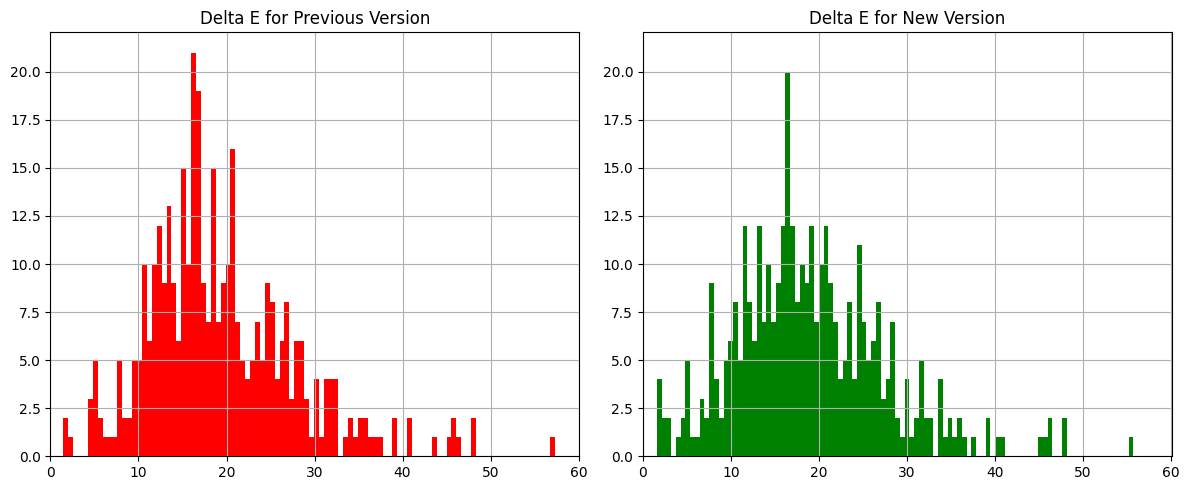

In [ ]:
# Create a figure and two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first histogram on the left subplot
df_val.diff_lab.hist(bins= 100, ax=axes[0], color='red')
axes[0].set_title('Delta E for Previous Version')

# Plot the second histogram on the right subplot
df_val.diff_lab_2.hist(bins=100, ax=axes[1], color='green')
axes[1].set_title('Delta E for New Version')

# Set the same y-axis limits for both histograms
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, y_max)
axes[1].set_ylim(0, y_max)

# Set the same x-axis limits for both histograms
x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
axes[0].set_xlim(0, x_max)
axes[1].set_xlim(0, x_max)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

We can also look at Delta E by product category. As before, we see that 'Delta E' is tends to be larger for 'lipstick'.

However, there has been some improvement.

* Blush: Delta E was, on average, 16, and now it is 15.8
* Lipgloss: Delta E was, on average, 19, and now it is 18.5
* Lipliner: Delta E was, on average, 24.4, now it is 24.2
* Lipstick: Delta E was, on average, 21.4, now it is 21.2

The Delta E sd decreased considerably, so the color identification is more reliable:

* Blush: Decreased from 58.4 to 50.6
* Lipgloss: Decreased from 63.2 to 62.2
* Lipliner: Decreased from 110.3 to 95.1
* Lipstick: Decreased from 77.4 to 75


/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


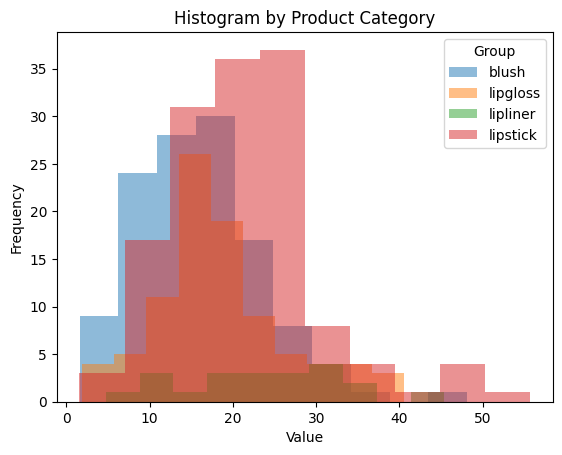

In [ ]:
# histogram with delta E by product category
# Create a figure and axis
fig, ax = plt.subplots()

# Group by the 'Group' column and plot a histogram for each group
for name, group in df_val.groupby('category'):
    ax.hist(group['diff_lab_2'], bins=10, alpha=0.5, label=name)

# Add labels and legend
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram by Product Category')
ax.legend(title='Group')

# Show the plot
plt.show()

In [ ]:
product_deltaE = df_val.diff_lab_2.groupby(df_val.category).mean()
product_deltaE = product_deltaE.reset_index()
product_deltaE.columns = ['product category', 'Delta E']

print('Table: DeltaE (mean) by Product')
product_deltaE

Table: DeltaE (mean) by Product


,product category,Delta E
0,blush,15.828191
1,lipgloss,18.586076
2,lipliner,24.233421
3,lipstick,21.260096


In [ ]:
product_deltaE = df_val.diff_lab_2.groupby(df_val.category).var()
product_deltaE = product_deltaE.reset_index()
product_deltaE.columns = ['product category', 'Delta E']

print('Table: DeltaE (var) by Product')
product_deltaE

Table: DeltaE (var) by Product


,product category,Delta E
0,blush,58.400358
1,lipgloss,63.294599
2,lipliner,95.145035
3,lipstick,77.443572


# Round 3: Checking Individual Images in Validation Set and Making Changes to Algorithm

In [225]:
metadata = pd.read_csv('/content/drive/MyDrive/data_4_cluster_output.csv')

## Looking at Specific Images and Color Prediction

I look at a number of images that had the worst prediction in the training set. Specifically, the worst case is below. This image is interesting because it is a PNG image. In my code, I had added a specific section to deal with PNG images because they have a different number of `channels` when they are transformed into an array. I found an error in which the transformation from RGB to CIELAB was incorrect for PNG images. Moreover, I found that I could also remover any cluster that was white or black, like I had done for the non-PNG images. I do this in the following section:

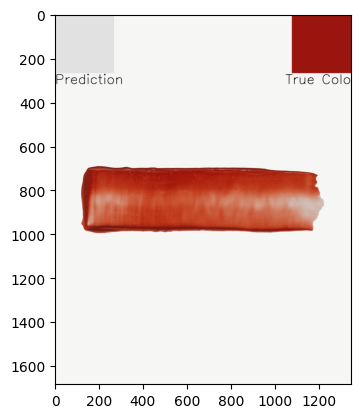

In [232]:
import ast
i=180
path = '/content/drive/MyDrive/makeup_img/' + str(metadata.img_name[180])
swatch = cv2.imread(path)
RGB_img = cv2.cvtColor(swatch, cv2.COLOR_BGR2RGB)

# Display the original image
plt.imshow(RGB_img)

# Overlay a square with the mean RGB color
# Here, we create a small patch of color in the top-left corner
height, width, _ = RGB_img.shape
square_size = min(height, width) // 5  # Size of the square relative to the image size

# predicted color
pred_lab =  ast.literal_eval(metadata.mean_lab_2[i])
xyz_pred = color.lab2xyz(pred_lab)
rgb_pred = color.xyz2rgb(xyz_pred)
rgb_pred = rgb_pred.reshape(3)
rgb_pred = (rgb_pred * 255).astype(int)
square_patch = np.ones((square_size, square_size, 3)) * rgb_pred # Create the square with the mean RGB color

# Ground truth color
ground_truth_col_lab = list(map(float, metadata.ground_truth_CIELAB[i].strip('[]').split()))
# Convert CIELAB to XYZ to RGB
xyz_ground_truth= color.lab2xyz(ground_truth_col_lab)
rgb_ground_truth = color.xyz2rgb(xyz_ground_truth)
rgb_ground_truth = rgb_ground_truth.reshape(3)
rgb_ground_truth = np.clip(rgb_ground_truth, 0, 1)

# Convert RGB values to [0, 255] for standard representation
rgb_ground_truth = (rgb_ground_truth * 255).astype(int)

square_patch_truth = np.ones((square_size, square_size, 3)) * rgb_ground_truth  # Create the square with the mean RGB color

# Place the square patch on the image
RGB_img[:square_size, :square_size] = square_patch

# Place the square patch on the image
# Calculate the starting point on the right side
start_col = RGB_img.shape[1] - square_size  # Start from the right edge minus the square size

# Place the square patch on the top right corner
RGB_img[:square_size, start_col:] = square_patch_truth

# Define text to add below the square patch
text = "True Color"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 2
font_thickness = 2
text_color = (0, 0, 0)  # White text color

# Calculate text position (starting just below the square)
text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
text_x = start_col + (square_size - text_size[0]) // 2  # Center the text horizontally
text_y = square_size + text_size[1] + 5  # Slightly below the square patch

# Define text to add below the square patch
text2 = "Prediction"
text_size2 = cv2.getTextSize(text2, font, font_scale, font_thickness)[0]
text_x2 = 0
text_y2 = square_size + text_size[1] + 5  # Slightly below the square patch

# Add text to the image
RGB_img = cv2.putText(RGB_img, text, (text_x, text_y), font, font_scale, text_color, font_thickness)
# Add text to the image
RGB_img = cv2.putText(RGB_img, text2, (text_x2, text_y2), font, font_scale, text_color, font_thickness)

# Display the image with the overlay
plt.imshow(RGB_img)
plt.show()

## Improving the algorithm

I made changes, particularly, in the section where it was `if num_channels == 1:` which is where PNG images are analyzed.

In [177]:
def analyze_image_colors(image_path, num_clusters=4):
    """
    Analyzes the colors in an image using k-means clustering and converts the dominant color
    to CIELAB color space.

    Parameters:
    - image_path (str): Path to the image file.
    - num_clusters (int): Number of clusters for k-means.

    Returns:
    - tuple: Average color and most frequent color in CIELAB color space.
    """

    # Read the image
    im = Image.open(image_path)

    # Optionally resize the image to reduce processing time
    im = im.resize((150, 150))

    # Convert the image to a numpy array
    ar = np.asarray(im)

    # Variance in color values
    sd_color = np.sqrt(np.var(ar))

    # Store the shape of the array
    shape = ar.shape

    # Check the number of channels in the image
    if len(shape) == 2:
    # No need to convert to RGB; use grayscale values directly
      num_channels = 1
    elif len(shape) == 3 and shape[2] in [3, 4]:
      # RGB or RGBA image
      if shape[2] == 4:
      # Remove the alpha channel
        ar = ar[:, :, :3]
      num_channels = 3
    else:
      raise ValueError("Unsupported image format")

    shape = ar.shape

    # Reshape the array for clustering
    ar = ar.reshape(np.prod(shape[:2]), num_channels).astype(float)

    # Perform k-means clustering to find color clusters
    codes, dist = scipy.cluster.vq.kmeans(ar, num_clusters)

    # Assign each pixel to a cluster and count occurrences
    vecs, dist = scipy.cluster.vq.vq(ar, codes)
    counts, bins = np.histogram(vecs, len(codes))

    # Find the index of the most frequent cluster
    index_max = np.argmax(counts)
    peak = codes[index_max]

    # Convert the average color from RGB or grayscale to CIELAB
    if num_channels == 1:
      peak_rgb = np.array([peak[0], 0, 0]) / 255
      peak_xyz = color.rgb2xyz(peak_rgb)  # Convert to XYZ
      peak_lab = color.xyz2lab(peak_xyz)  # Convert to CIELAB

      # Calculate difference between peak & white
      diff_peak_white = deltaE_ciede2000(peak_lab, [100,0,0])

      # Calculate difference between peak & black
      diff_peak_black = deltaE_ciede2000(peak_lab, [0,0,0])

      # Filter out clusters with black or white if Delta E < 5
      if diff_peak_white < 5:
        codes = np.delete(codes, index_max, axis=0)
      if diff_peak_black < 5:
        codes = np.delete(codes, index_max, axis=0)

      # Average over the color of the clusters after dropping peak
      columns_average = codes.mean(axis=0)
      mean_rgb = np.array([columns_average[0], 0, 0]) / 255 # Normalize RGB values to [0, 1]
      mean_xyz = color.rgb2xyz(mean_rgb)  # Convert to XYZ
      mean_lab = color.xyz2lab(mean_xyz)  # Convert to CIELAB

    else:
      peak_rgb = np.array(peak).reshape(1, 1, num_channels) / 255  # Normalize RGB values to [0, 1]
      peak_xyz = color.rgb2xyz(peak_rgb)  # Convert to XYZ
      peak_lab = color.xyz2lab(peak_xyz)  # Convert to CIELAB

      # Calculate difference between peak & white
      diff_peak_white = deltaE_ciede2000(peak_lab[0][0], [100,0,0])

      # Calculate difference between peak & black
      diff_peak_black = deltaE_ciede2000(peak_lab[0][0], [0,0,0])

      # Filter out clusters with black or white if Delta E < 5
      if diff_peak_white < 5:
        codes = np.delete(codes, index_max, axis=0)
      if diff_peak_black < 5:
        codes = np.delete(codes, index_max, axis=0)

      # Average over the color of the clusters after dropping peak
      columns_average = codes.mean(axis=0)
      mean_rgb = np.array(columns_average).reshape(1, 1, num_channels) / 255  # Normalize RGB values to [0, 1]
      mean_xyz = color.rgb2xyz(mean_rgb)  # Convert to XYZ
      mean_lab = color.xyz2lab(mean_xyz)  # Convert to CIELAB

    if num_channels == 1:
      return mean_lab, peak_lab
    else:
      return mean_lab[0][0], peak_lab[0][0]

In [156]:
df = metadata

In [157]:
df['mean_lab_3'] = pd.Series(dtype='object')
df['peak_lab_3'] = pd.Series(dtype='object')

Applying the algorithm to all of the images and savin the results:

In [178]:
for i in range(len(df)):
  #print(str(df.img_name[i]))
  path = '/content/drive/MyDrive/makeup_img/' + str(df.img_name[i])
  colors_output = analyze_image_colors(path)
  mean_value = list(colors_output[0])
  peak_value = list(colors_output[1])
  df.at[i, 'mean_lab_3'] = mean_value
  df.at[i, 'peak_lab_3'] = peak_value

Looking at the specific image I had presented in the previous section, we see a big improvement in the color prediction.

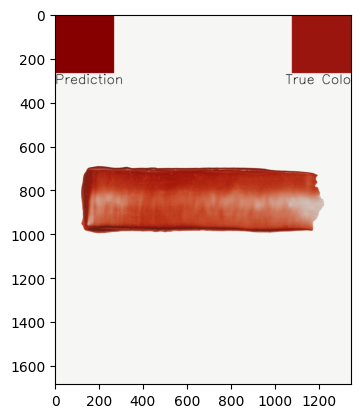

In [231]:
i=180
path = '/content/drive/MyDrive/makeup_img/' + str(df.img_name[180])
swatch = cv2.imread(path)
RGB_img = cv2.cvtColor(swatch, cv2.COLOR_BGR2RGB)

# Display the original image
plt.imshow(RGB_img)

# Overlay a square with the mean RGB color
# Here, we create a small patch of color in the top-left corner
height, width, _ = RGB_img.shape
square_size = min(height, width) // 5  # Size of the square relative to the image size

# predicted color
pred_lab =  df.mean_lab_3[i]
xyz_pred = color.lab2xyz(pred_lab)
rgb_pred = color.xyz2rgb(xyz_pred)
rgb_pred = rgb_pred.reshape(3)
rgb_pred = (rgb_pred * 255).astype(int)
square_patch = np.ones((square_size, square_size, 3)) * rgb_pred # Create the square with the mean RGB color

# Ground truth color
ground_truth_col_lab = list(map(float, df.ground_truth_CIELAB[i].strip('[]').split()))
# Convert CIELAB to XYZ to RGB
xyz_ground_truth= color.lab2xyz(ground_truth_col_lab)
rgb_ground_truth = color.xyz2rgb(xyz_ground_truth)
rgb_ground_truth = rgb_ground_truth.reshape(3)
rgb_ground_truth = np.clip(rgb_ground_truth, 0, 1)

# Convert RGB values to [0, 255] for standard representation
rgb_ground_truth = (rgb_ground_truth * 255).astype(int)

square_patch_truth = np.ones((square_size, square_size, 3)) * rgb_ground_truth  # Create the square with the mean RGB color

# Place the square patch on the image
RGB_img[:square_size, :square_size] = square_patch

# Place the square patch on the image
# Calculate the starting point on the right side
start_col = RGB_img.shape[1] - square_size  # Start from the right edge minus the square size

# Place the square patch on the top right corner
RGB_img[:square_size, start_col:] = square_patch_truth

# Define text to add below the square patch
text = "True Color"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 2
font_thickness = 2
text_color = (0, 0, 0)  # White text color

# Calculate text position (starting just below the square)
text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
text_x = start_col + (square_size - text_size[0]) // 2  # Center the text horizontally
text_y = square_size + text_size[1] + 5  # Slightly below the square patch

# Define text to add below the square patch
text2 = "Prediction"
text_size2 = cv2.getTextSize(text2, font, font_scale, font_thickness)[0]
text_x2 = 0
text_y2 = square_size + text_size[1] + 5  # Slightly below the square patch

# Add text to the image
RGB_img = cv2.putText(RGB_img, text, (text_x, text_y), font, font_scale, text_color, font_thickness)
# Add text to the image
RGB_img = cv2.putText(RGB_img, text2, (text_x2, text_y2), font, font_scale, text_color, font_thickness)

# Display the image with the overlay
plt.imshow(RGB_img)
plt.show()

### Validation

I follow the same steps as before.

First, I calculate Delta E between the color output from the algorithm and the 'ground truth' color.

In [182]:
df['diff_lab_3'] = pd.Series(dtype='object')

for i in range(len(df)):
  if df.ground_truth[i] == 1:
    diff = deltaE_ciede2000(df.mean_lab_3[i], list(map(float, df.ground_truth_CIELAB[i].strip('[]').split())))
    df.loc[i, 'diff_lab_3'] = diff
  else:
    df.loc[i, 'diff_lab_3'] = np.nan

Second, I plot a histogram for previous Delta E (red) and a histogram for the new Delta E (green) for each observation in the validation set.

The mean Delta E previously was 19.4, and now it is 15.68, meaning that, on average, the color identified is considerably closer to 'ground truth' than it was previously.

The table belows shows a comparison of Delta E values between the first version and this last version of the algorithm (`diff_lab` and `diff_lab_3`). The values represent how many observations fall within specific ranges of Delta E (e.g., 0-5, 5-10, etc.).

- (0, 10]: A lot of images have a low Delta E that had a much higher Delta E with the first version. Previously, 7 images had a Delta E below 10, and now over 100 have a Delta E below 10.
- (10, 20]: Again, we see big improvements here as well.
- (20, 30] and higher: The observations decrease in both versions, but even though there are more gains with the new algorithm, a few cases perform worse.

Overall, the final version (diff_lab_3) performs considerably better.

In [280]:
# Define the bins for the ranges you want to check
bins = np.arange(0, 55, 5)  # Bins from 0 to 100 with a step of 10

# Use pd.cut to segment and sort data values into bins
df_val['diff_lab_bin'] = pd.cut(df_val['diff_lab'], bins)
df_val['diff_lab_3_bin'] = pd.cut(df_val['diff_lab_3'], bins)

# Create a pivot table to count occurrences within each bin for both variables
table = pd.pivot_table(df_val,
                       values='diff_lab',
                       index='diff_lab_bin',
                       columns='diff_lab_3_bin',
                       aggfunc='count',
                       fill_value=0)

# Display the table
styled_table = table.style.background_gradient(cmap='viridis').set_caption("Occurrences of Delta E in Specified Ranges")
styled_table

diff_lab_3_bin,"(0, 5]","(5, 10]","(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]","(35, 40]","(40, 45]","(45, 50]"
diff_lab_bin,,,,,,,,,,
"(0, 5]",3,4,2,0,0,0,0,0,0,0
"(5, 10]",7,9,5,1,1,0,0,0,0,0
"(10, 15]",24,21,25,7,3,0,0,0,0,0
"(15, 20]",11,19,31,33,7,6,5,1,0,0
"(20, 25]",4,5,16,22,11,5,2,0,0,2
"(25, 30]",5,3,5,10,13,5,2,1,0,0
"(30, 35]",1,1,0,4,7,6,1,0,0,0
"(35, 40]",2,0,0,0,4,3,0,0,0,0
"(40, 45]",0,0,0,0,1,1,1,0,0,0


In [268]:
round(df_val.diff_lab_3.mean(),2)

15.68

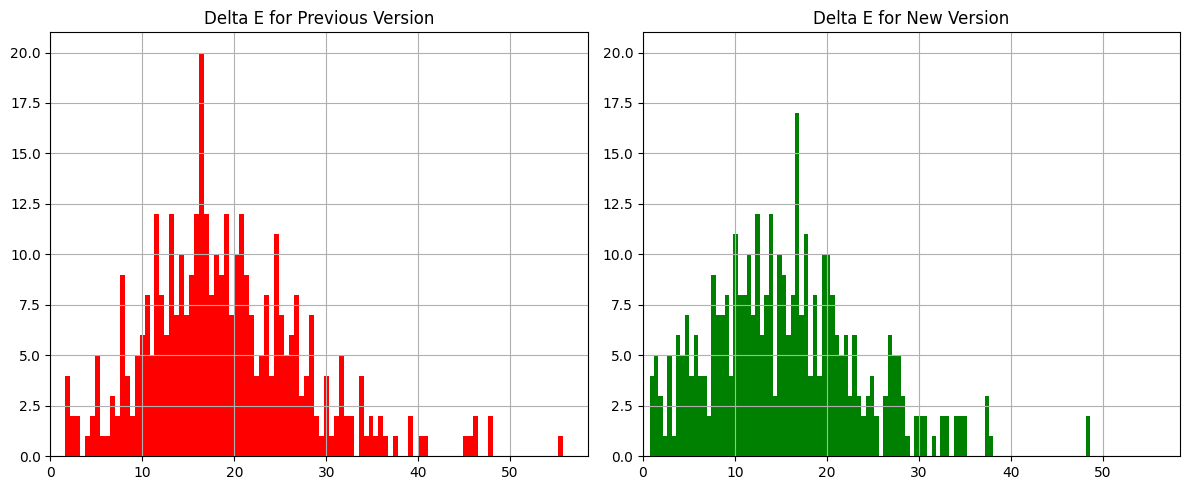

In [197]:
# Create a figure and two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first histogram on the left subplot
df_val.diff_lab_2.hist(bins= 100, ax=axes[0], color='red')
axes[0].set_title('Delta E for Previous Version')

# Plot the second histogram on the right subplot
df_val.diff_lab_3.hist(bins=100, ax=axes[1], color='green')
axes[1].set_title('Delta E for New Version')

# Set the same y-axis limits for both histograms
y_max = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, y_max)
axes[1].set_ylim(0, y_max)

# Set the same x-axis limits for both histograms
x_max = max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])
axes[0].set_xlim(0, x_max)
axes[1].set_xlim(0, x_max)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

We can also look at Delta E by product category. As before, we see that 'Delta E' is tends to be larger for 'lipstick'.

However, there has been considerable improvement for lipgloss, lipliner, and lipstick:

* Blush: Delta E was, on average, 15.8, and decreased to 14.25.
* Lipgloss: Delta E was, on average, 18.5, and decreased to 15.6.
* Lipliner: Delta E was, on average, 24.2, and decreased to 18.21.
* Lipstick: Delta E was, on average, 21.2, and decreased to 16.5.

The Delta E sd decreased considerably for the following two product categories, so the color identification is more reliable:

* Lipgloss: Decreased from 62.2 to 54.7.
* Lipliner: Decreased from 95.1 to 60.5.


/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.10/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


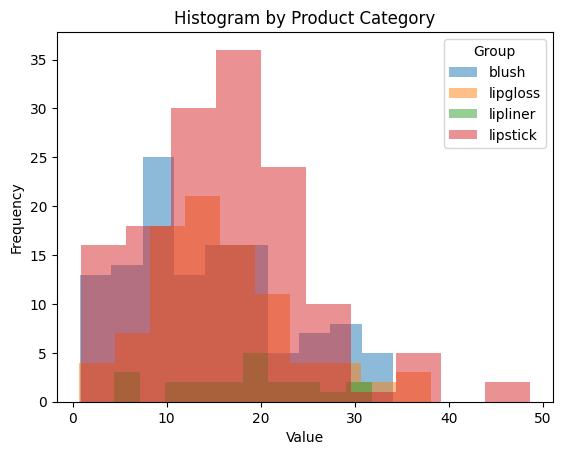

In [198]:
# histogram with delta E by product category
# Create a figure and axis
fig, ax = plt.subplots()

# Group by the 'Group' column and plot a histogram for each group
for name, group in df_val.groupby('category'):
    ax.hist(group['diff_lab_3'], bins=10, alpha=0.5, label=name)

# Add labels and legend
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Histogram by Product Category')
ax.legend(title='Group')

# Show the plot
plt.show()

In [199]:
product_deltaE = df_val.diff_lab_3.groupby(df_val.category).mean()
product_deltaE = product_deltaE.reset_index()
product_deltaE.columns = ['product category', 'Delta E']

print('Table: DeltaE (mean) by Product')
product_deltaE

Table: DeltaE (mean) by Product


,product category,Delta E
0,blush,14.259164
1,lipgloss,15.658005
2,lipliner,18.212434
3,lipstick,16.544623


In [200]:
product_deltaE = df_val.diff_lab_3.groupby(df_val.category).var()
product_deltaE = product_deltaE.reset_index()
product_deltaE.columns = ['product category', 'Delta E']

print('Table: DeltaE (var) by Product')
product_deltaE

Table: DeltaE (var) by Product


,product category,Delta E
0,blush,70.493799
1,lipgloss,54.707428
2,lipliner,60.510703
3,lipstick,75.902785


## Checking Individual Images with Varying Levels of Delta E

The set of six figures displays makeup images (blush, lipstick, or lipgloss) from the validation set, each accompanied by a comparison of the predicted and true colors of the makeup. The Delta E values, which range from 0-5, 5-10, 10-15, and beyond, indicate the difference between the predicted and true colors. For lower Delta E values, the predicted color closely matches the true color, reflecting higher accuracy. As Delta E increases, the prediction accuracy decreases, often due to interference from packaging and shadows, which distort the true color and lead to less accurate predictions.

In [266]:
image_selection = [81, 2, 9, 19, 498, 156]
category_deltaE = ['Delta E < 5', 'Delta E between [5, 10)]', 'Delta E between [10, 15)]', 'Delta E between [15, 20)]','Delta E between [20, 25)]','Delta E between [25, 30)]' ]

df_subset = df.iloc[image_selection]
df_subset = df_subset.reset_index()

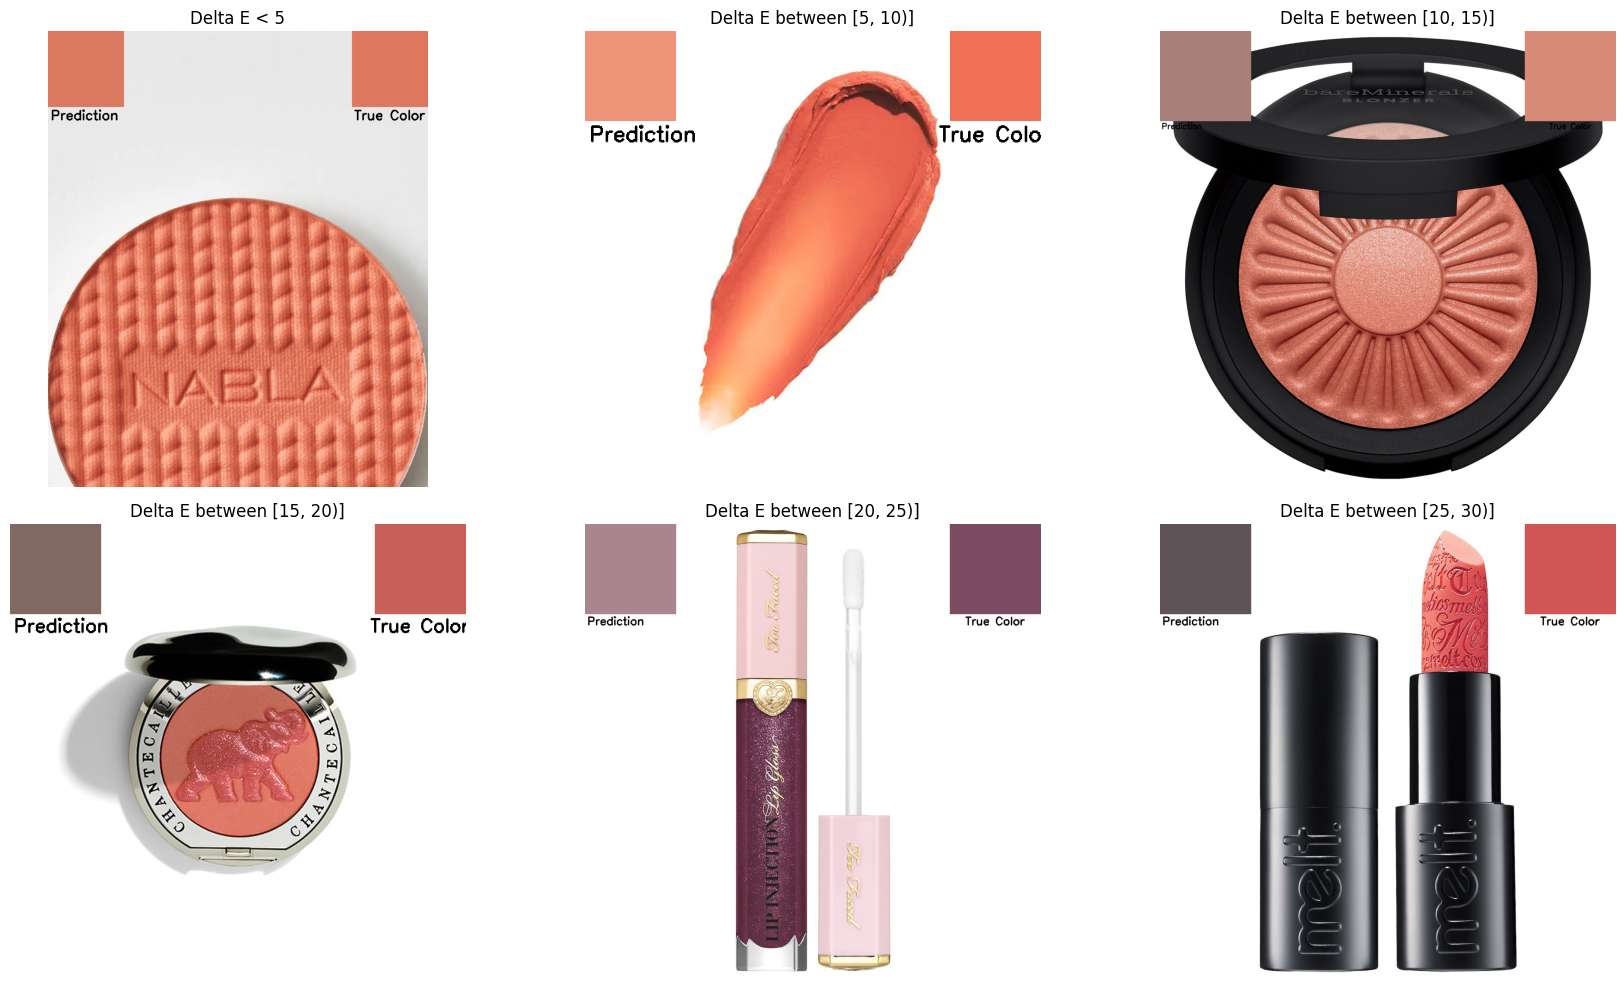

In [267]:
# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Adjust figsize as needed

for i in range(len(df_subset)):  # Assuming you have a loop or similar structure to process 6 images
    # Get the current subplot's axis
    path = '/content/drive/MyDrive/makeup_img/' + str(df_subset.img_name[i])
    # Read test image
    swatch = cv2.imread(path)
    RGB_img = cv2.cvtColor(swatch, cv2.COLOR_BGR2RGB)

    # Get the current subplot
    ax = axes[i // 3, i % 3]  # Row: i // 3, Column: i % 3

    # Assuming RGB_img is defined and available for each iteration
    ax.imshow(RGB_img)  # Display the original image on the subplot

    # Square patch parameters
    height, width, _ = RGB_img.shape
    square_size = min(height, width) // 5  # Size of the square relative to the image size

    # Predicted color square
    pred_lab = df_subset.mean_lab_3[i]
    xyz_pred = color.lab2xyz(pred_lab)
    rgb_pred = color.xyz2rgb(xyz_pred)
    rgb_pred = np.clip(rgb_pred.reshape(3), 0, 1)  # Ensure values are within [0, 1] range
    rgb_pred = (rgb_pred * 255).astype(int)
    square_patch_pred = np.ones((square_size, square_size, 3)) * rgb_pred

    # Ground truth color square
    ground_truth_col_lab = list(map(float, df_subset.ground_truth_CIELAB[i].strip('[]').split()))
    xyz_ground_truth = color.lab2xyz(ground_truth_col_lab)
    rgb_ground_truth = color.xyz2rgb(xyz_ground_truth)
    rgb_ground_truth = np.clip(rgb_ground_truth.reshape(3), 0, 1)  # Ensure values are within [0, 1] range
    rgb_ground_truth = (rgb_ground_truth * 255).astype(int)
    square_patch_truth = np.ones((square_size, square_size, 3)) * rgb_ground_truth

    # Place the predicted color square on the top-left corner of the image
    RGB_img[:square_size, :square_size] = square_patch_pred

    # Place the ground truth color square on the top-right corner of the image
    start_col = RGB_img.shape[1] - square_size
    RGB_img[:square_size, start_col:] = square_patch_truth

    # Add text under the squares
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.8
    font_thickness = 2
    text_color = (0, 0, 0)  # black text color

    # Predicted color text
    text_pred = "Prediction"
    text_size_pred = cv2.getTextSize(text_pred, font, font_scale, font_thickness)[0]
    text_x_pred = 5  # Left-aligned text under the left square
    text_y_pred = square_size + text_size_pred[1] + 5
    RGB_img = cv2.putText(RGB_img, text_pred, (text_x_pred, text_y_pred), font, font_scale, text_color, font_thickness)

    # Ground truth color text
    text_truth = "True Color"
    text_size_truth = cv2.getTextSize(text_truth, font, font_scale, font_thickness)[0]
    text_x_truth = start_col + (square_size - text_size_truth[0]) // 2  # Centered text under the right square
    text_y_truth = square_size + text_size_truth[1] + 5
    RGB_img = cv2.putText(RGB_img, text_truth, (text_x_truth, text_y_truth), font, font_scale, text_color, font_thickness)

    # Add a title to each subplot
    ax.set_title(category_deltaE[i])  # Customize the title as needed

    # Display the modified image in the current subplot
    ax.imshow(RGB_img)
    ax.axis('off')  # Hide axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


# Testing the Final Algorithm Iteration

In the final stage of the project, I applied the chosen model to the test set to evaluate its performance. This step is crucial to ensure that the model generalizes well to unseen data and maintains its accuracy in identifying and matching makeup colors. By analyzing the results on the test set, I can confirm whether the improvements made during the validation phase translate into reliable performance in real-world scenarios.

In [202]:
df_test = pd.merge(df, test_df['id'], how='inner', on='id')
df_test.shape

(102, 25)

In [203]:
print('The mean Delta E for the validation set is:')
round(df_test.diff_lab_3.mean(),2)

The mean Delta E for the validation set is:


14.48

In [204]:
print('The mean Delta E for the validation set is:')
round(df_test.diff_lab_3.median(),2)

The mean Delta E for the validation set is:


14.04

In [205]:
product_deltaE = df_test.diff_lab_3.groupby(df_test.category).mean()
product_deltaE = product_deltaE.reset_index()
product_deltaE.columns = ['product category', 'Delta E']

print('Table: DeltaE (mean) by Product')
product_deltaE

Table: DeltaE (mean) by Product


,product category,Delta E
0,blush,10.577755
1,lipgloss,14.028827
2,lipliner,17.884756
3,lipstick,18.316745


In summary, the results show the following:

- Blush: Delta E was 14.2, on average, for the validation set, and for the testing set it is 10.5.
- Lipgloss: Delta E was 15.6 for the validation set, and for the test set it is 14.0.
- Lipliner: Delta E was, on average, 18.2 for the validation set, and for the test set it is  17.9. Liplinear is also the one with the highest variance in Delta E.
- Lipstick: Delta E was, on average, 16.5 for the validation set, and now for the test set, it is 18.3.

# Conclusion

The results indicate that the model performs consistently across the validation and test sets for most makeup types, with minor variations in Delta E. The decrease in Delta E for blush from 15.8 in the first round to 10.6 suggests improved accuracy in color matching for this product. Even greater improvements in other products

Overall, while the model shows strong generalization for blush and reasonable stability for lipgloss and lipstick, further refinement may be needed for lipliner to reduce variability and improve color accuracy.